In [ ]:
!unzip "/content/drive/My Drive/Hackathons/Weekend Hackathons/ZS ADS Hackathon/bb9f6a4cbd5311ea.zip"

Importing required Pakcages

In [1]:
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Creating calendar 

In [2]:
 def create_calendar(start='2016-05-01', end='2018-07-31'):
   df = pd.DataFrame({"date": pd.date_range(start, end)})
   return df

calendar = create_calendar()
calendar['date'] = calendar['date'].dt.strftime('%Y-%m-%d')
calendar['year'] =  pd.DatetimeIndex(calendar['date']).year
calendar['month'] =  pd.DatetimeIndex(calendar['date']).month
calendar['week'] =  pd.DatetimeIndex(calendar['date']).week

Creating function to impute nan with mean

In [3]:
def impute_mean(series):
    return series.fillna(series.mean())

Importing input files

In [4]:
sales2016 = pd.read_csv("/content/Dataset/2016_sales_data.csv")
sales2017 = pd.read_csv("/content/Dataset/2017_sales_data.csv")
sales2018 = pd.read_csv("/content/Dataset/2018_sales_data.csv")
with open("/content/Dataset/city_dict.json") as json_file:
    city_number = json.load(json_file)
city_number= pd.DataFrame(city_number.items(), columns=['citynum', 'city'])
historical_discount = pd.read_csv("/content/Dataset/historical_discount.csv")
foot_fall = pd.read_csv("/content/Dataset/foot_fall.csv")
product_info = pd.read_csv("/content/Dataset/product_information.csv")
expected_discount = pd.read_csv("/content/Dataset/expected_discount.csv")
test_data = pd.read_csv("/content/Dataset/test_data.csv")
submissions = pd.read_csv("/content/Dataset/sample_submission.csv")

Sales data looks heavy and processing will take a lot of time. Also, data is very variable at day level. Searched for forecasting methodology of sales and saw no one predicting sales at day level. So, will roll up the data at week level and predict the sales and then bring it back to day level. Some sales data also looks negative and when I ran the model by making it zero, it gave me better score. So changed all negative sales numbers to zero

In [5]:
sales2016 = sales2016.loc[pd.DatetimeIndex(sales2016['date']).month>4] 
sales = pd.concat([sales2016, sales2017, sales2018], ignore_index=True)
sales['year'] =  pd.DatetimeIndex(sales['date']).year
sales['month'] =  pd.DatetimeIndex(sales['date']).month
sales['week'] =  pd.DatetimeIndex(sales['date']).week
sales= sales.drop('date',axis = 1)
salesrolled = sales.groupby(['city','product','week','month','year'])['sales'].sum()
sales = sales.merge(salesrolled, on = ['city','product','week','month','year'])
sales= sales.drop('sales_x',axis = 1) 
sales = sales.drop_duplicates(keep= 'first').reset_index(drop=True)
sales = sales.mask(sales < 0, 0)

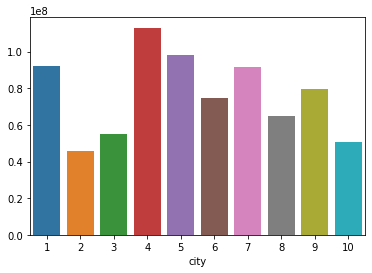

In [ ]:
x = sales.groupby(["city"])["sales_y"].sum().index
y=sales.groupby(["city"])["sales_y"].sum().values
sns.barplot(x,y)

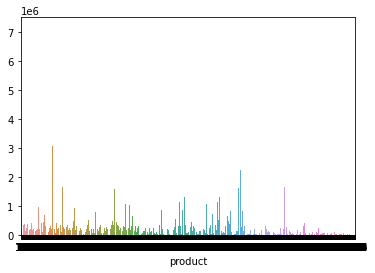

In [ ]:
x = sales.groupby(["product"])["sales_y"].sum().index
y=sales.groupby(["product"])["sales_y"].sum().values
sns.barplot(x,y)

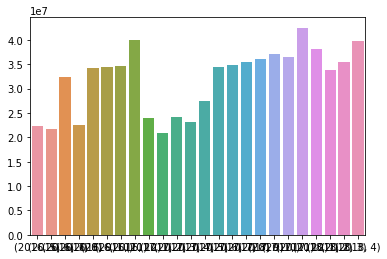

In [ ]:
x = sales.groupby(["year","month"])["sales_y"].sum().index
y=sales.groupby(["year","month"])["sales_y"].sum().values
sns.barplot(x,y)

In [ ]:
sales.describe()

,city,product,year,month,week,sales_y
count,2.892930e+06,2.892930e+06,2.892930e+06,2.892930e+06,2.892930e+06,2.892930e+06
mean,5.507595e+00,1.321379e+03,2.016912e+03,6.629410e+00,2.688618e+01,2.646874e+02
std,2.863543e+00,8.393827e+02,7.012095e-01,3.498629e+00,1.517389e+01,5.455931e+02
min,1.000000e+00,1.000000e+00,2.016000e+03,1.000000e+00,1.000000e+00,-1.796000e+03
25%,3.000000e+00,6.080000e+02,2.016000e+03,4.000000e+00,1.300000e+01,5.200000e+01
50%,6.000000e+00,1.226000e+03,2.017000e+03,7.000000e+00,2.700000e+01,1.280000e+02
75%,8.000000e+00,1.963000e+03,2.017000e+03,1.000000e+01,4.000000e+01,2.840000e+02
max,1.000000e+01,3.324000e+03,2.018000e+03,1.200000e+01,5.200000e+01,8.802400e+04


Footfall data is in Pivotted down format. Will Pivot down and look at the data. Also, data is missing for Test set. So will to predict footffall for Test set

In [ ]:
foot_fall.describe()

,1/2/2015,1/3/2015,1/4/2015,1/5/2015,1/6/2015,1/7/2015,1/8/2015,1/9/2015,1/10/2015,1/11/2015,1/12/2015,1/13/2015,1/14/2015,1/15/2015,1/16/2015,1/17/2015,1/18/2015,1/19/2015,1/20/2015,1/21/2015,1/22/2015,1/23/2015,1/24/2015,1/25/2015,1/26/2015,1/27/2015,1/28/2015,1/29/2015,1/30/2015,1/31/2015,2/1/2015,2/2/2015,2/3/2015,2/4/2015,2/5/2015,2/6/2015,2/7/2015,2/8/2015,2/9/2015,2/10/2015,...,3/22/2018,3/23/2018,3/24/2018,3/25/2018,3/26/2018,3/27/2018,3/28/2018,3/29/2018,3/30/2018,3/31/2018,4/1/2018,4/2/2018,4/3/2018,4/4/2018,4/5/2018,4/6/2018,4/7/2018,4/8/2018,4/9/2018,4/10/2018,4/11/2018,4/12/2018,4/13/2018,4/14/2018,4/15/2018,4/16/2018,4/17/2018,4/18/2018,4/19/2018,4/20/2018,4/21/2018,4/22/2018,4/23/2018,4/24/2018,4/25/2018,4/26/2018,4/27/2018,4/28/2018,4/29/2018,4/30/2018
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,14310.400000,11460.400000,12236.400000,15157.200000,15605.200000,11299.600000,10456.400000,10955.600000,9596.000000,10770.000000,13670.400000,14658.800000,10064.80000,10240.80000,11071.600000,9925.600000,10764.000000,14082.000000,14668.800000,10638.000000,9790.000000,10372.400000,9176.800000,10754.800000,14133.200000,14236.800000,10018.800000,9646.400000,10625.200000,10383.200000,11938.800000,15283.600000,14731.600000,11168.800000,11146.400000,11310.000000,10601.600000,11647.600000,13045.600000,10634.400000,...,10460.000000,11918.400000,11796.000000,11711.200000,13799.20000,13102.800000,10305.200000,9936.400000,10523.600000,10658.800000,12843.200000,16173.200000,16596.000000,11902.800000,11301.200000,11498.00000,10500.800000,12225.600000,14775.200000,15023.200000,10950.000000,11490.800000,11209.20000,10191.600000,12122.000000,13342.800,14382.000000,13924.400000,12937.600000,13121.200000,11340.800000,12204.800000,15114.800000,14603.200000,10626.000000,10256.400000,10950.800000,9771.600000,11985.600000,15618.400000
std,3764.011194,2849.006969,3156.764279,3949.189306,4350.641557,2912.809076,2705.620455,2930.239854,2448.001452,2828.876023,3311.670515,3827.482863,2579.66668,2721.02582,2956.002977,2539.842305,2816.532147,3362.214218,3903.642424,2773.541178,2382.098608,2641.545978,2217.597338,2721.854303,3611.637019,3799.689718,2481.167503,2475.994041,2923.228687,2689.687169,3129.404658,4205.648456,4087.792754,2892.280484,2849.899616,2974.167447,2721.163281,3061.751685,3804.003599,2671.055854,...,2330.124269,2965.135005,2105.433394,2979.272872,3308.12269,3028.446496,2277.215493,2235.597618,2727.675738,2488.658755,2909.627116,3934.006293,4366.669313,2678.169225,2448.426288,2875.36247,2438.523998,2911.506796,3490.504096,3675.098572,2507.529107,2507.951479,2679.48257,2406.029796,2794.418723,2659.231,3446.575756,3309.797147,2815.558804,3298.292649,2481.156576,2965.033438,3283.640825,3537.642052,2188.811347,2242.353882,2734.098137,2325.990312,3001.840147,3770.687506
min,8572.000000,6808.000000,6716.000000,8616.000000,9252.000000,6852.000000,6220.000000,6808.000000,5688.000000,6252.000000,8080.000000,8876.000000,6100.00000,6284.00000,6708.000000,6188.000000,6192.000000,8528.000000,8808.000000,6228.000000,6000.000000,6424.000000,5728.000000,6480.000000,8104.000000,8404.000000,6028.000000,5788.000000,6476.000000,6232.000000,6756.000000,9024.000000,8608.000000,6360.000000,6152.000000,663

In [6]:
foot_fall= foot_fall.melt(id_vars=["city"], 
        var_name="date", 
        value_name="footfall")
foot_fall = foot_fall.dropna()
foot_fall = pd.merge(foot_fall,city_number, on = 'city')
foot_fall['city'] = foot_fall['citynum'] 
foot_fall = foot_fall.drop('citynum',1)
foot_fall['date'] =foot_fall['date'].str.replace("/","-")
foot_fall['city'] = foot_fall['city'].astype(int)
foot_fall['year'] =  pd.DatetimeIndex(foot_fall['date']).year
foot_fall['month'] =  pd.DatetimeIndex(foot_fall['date']).month
foot_fall['week'] =  pd.DatetimeIndex(foot_fall['date']).week
foot_fall= foot_fall.drop('date',axis = 1) 
foot_fall_rolled = foot_fall.groupby(['city','week','month','year'])['footfall'].sum()
foot_fall = foot_fall.merge(foot_fall_rolled, on = ['city','week','month','year'])
foot_fall= foot_fall.drop('footfall_x',axis = 1) 
foot_fall = foot_fall.drop_duplicates(keep= 'first').reset_index(drop=True)
foot_fall = foot_fall[ [ col for col in foot_fall.columns if col != 'footfall_y' ] + ['footfall_y'] ]    

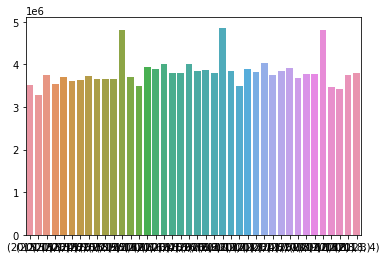

In [ ]:
x = foot_fall.groupby(["year","month"])["footfall_y"].sum().index
y=foot_fall.groupby(["year","month"])["footfall_y"].sum().values
sns.barplot(x,y)

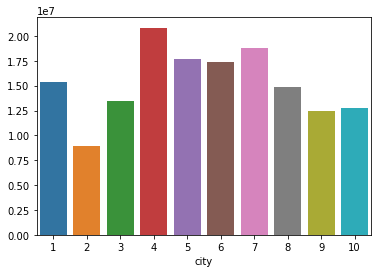

In [ ]:
x = foot_fall.groupby(["city"])["footfall_y"].sum().index
y=foot_fall.groupby(["city"])["footfall_y"].sum().values
sns.barplot(x,y)

Creating Footfall data for Test Set. Tried ARMIA first, but LightGbm gave me a better score, so will use LightGBM

In [7]:
test_data['year'] =  pd.DatetimeIndex(test_data['date']).year
test_data['month'] =  pd.DatetimeIndex(test_data['date']).month
test_data['week'] =  pd.DatetimeIndex(test_data['date']).week
test_data_for_footfall = test_data.drop(columns= ['id','product'])
test_data_for_footfall= test_data_for_footfall.drop('date',axis = 1) 
test_data_for_footfall= test_data_for_footfall.drop_duplicates(keep= 'first').reset_index(drop=True)

In [8]:
foot_fall_X_train = foot_fall.iloc[:,:-1].values

foot_fall_y_train = foot_fall.iloc[:,-1].values

foot_fall_X_test = test_data_for_footfall.iloc[:,:].values

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(foot_fall_X_train)
foot_fall_X_train= imp.transform(foot_fall_X_train)
foot_fall_X_test= imp.transform(foot_fall_X_test)
Scaler = StandardScaler()
Scaler.fit(foot_fall_X_train)
foot_fall_X_train = Scaler.transform(foot_fall_X_train)
foot_fall_X_test = Scaler.transform(foot_fall_X_test)

clf_footfall = LGBMRegressor(categorical_features =0)

clf_footfall.fit(foot_fall_X_train,foot_fall_y_train)

test_data_for_footfall['footfall_y'] = clf_footfall.predict(foot_fall_X_test)

Product Info: Looking at the data info, there are  ~2.5k product categories and subcategories out of the total ~3.5 products, which doesn't seem like a good feature to have. Removing those along with var_4 and var_7 which have same value



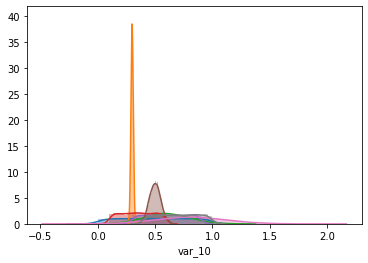

In [9]:
sns.distplot(product_info["var_1"])
sns.distplot(product_info["var_2"])
sns.distplot(product_info["var_3"])
sns.distplot(product_info["var_5"])
sns.distplot(product_info["var_6"])
sns.distplot(product_info["var_8"])
sns.distplot(product_info["var_9"])
sns.distplot(product_info["var_10"])

In [ ]:
product_info.nunique()

product                3389
product_category       2308
product_subcategory    2863
var_1                  3389
var_2                  3389
var_3                  3389
var_5                  3389
var_6                  3389
var_8                  3389
var_9                  3389
var_10                 3389
dtype: int64

In [ ]:
product_info.head()

,product,product_category,product_subcategory,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10
0,1,Cat_753,SubCat_3077,0.715514,0.299219,0.381067,0.0003,0.363847,0.300629,0.08,0.416806,1.171543,0.668805
1,2,Cat_643,SubCat_3774,0.075851,0.298774,0.852691,0.0003,0.409503,0.465912,0.08,0.545467,0.541547,0.401800
2,3,Cat_2804,SubCat_7454,0.285910,0.308168,0.531137,0.0003,0.168459,0.517364,0.08,0.521452,0.945024,0.631538
3,4,Cat_71,SubCat_5,0.544437,0.281760,0.530937,0.0003,0.291839,0.302639,0.08,0.519929,0.635492,0.991901
4,5,Cat_1556,SubCat_9403,0.852752,0.301493,0.343009,0.0003,0.286037,0.822326,0.08,0.462138,0.574709,0.792799


In [ ]:
product_info.describe()

,product,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10
count,3389.000000,3389.000000,3389.000000,3389.000000,3.389000e+03,3389.000000,3389.000000,3.389000e+03,3389.000000,3389.000000,3389.000000
mean,1695.000000,0.502423,0.300025,0.599648,3.000000e-04,0.349260,0.603023,8.000000e-02,0.499604,0.806147,0.702047
std,978.464358,0.286178,0.010287,0.198647,1.209064e-17,0.142723,0.174802,4.316629e-15,0.049441,0.304240,0.172882
min,1.000000,0.000936,0.263040,-0.147385,3.000000e-04,0.100090,0.300160,8.000000e-02,0.332469,-0.294912,0.400015
25%,848.000000,0.253101,0.293168,0.470882,3.000000e-04,0.225308,0.454379,8.000000e-02,0.465838,0.601223,0.551492
50%,1695.000000,0.498743,0.299938,0.599964,3.000000e-04,0.349353,0.601717,8.000000e-02,0.499734,0.809121,0.703019
75%,2542.000000,0.748209,0.306943,0.733991,3.000000e-04,0.473972,0.756619,8.000000e-02,0.532564,1.013195,0.854160
max,3389.000000,0.999823,0.334948,1.256447,3.000000e-04,0.599972,0.899998,8.000000e-02,0.644091,1.980311,0.999983


In [10]:
product_info = product_info.drop(['var_4','var_7','product_category','product_subcategory'],1)

Product discount is good feature to have looks like discount starts from Mid 2016. Good place to reduce size of the dataset and exxclude the extra Sales and just keep 2 years of sales. 
Also, number of records here look low. I will merge it with calendar which will help me in creating new features as well and at the last I will replace Null discount values with zero. 

In [11]:
historical_discount= historical_discount.melt(id_vars=["date","product"], 
        var_name="city", 
        value_name="discountflag")
expected_discount= expected_discount.melt(id_vars=["date","product"], 
        var_name="city", 
        value_name="discountflag")
discount = pd.concat([historical_discount, expected_discount], ignore_index=True)
discount['city'] = discount['city'].str.replace("Discount_","")
discount = pd.merge(discount,city_number, on = 'city')
discount['city'] = discount['citynum'] 
discount = discount.drop('citynum',1)
discount['city'] = discount['city'].astype(int)
discount['year'] =  pd.DatetimeIndex(discount['date']).year
discount['month'] =  pd.DatetimeIndex(discount['date']).month
discount['week'] =  pd.DatetimeIndex(discount['date']).week

In [ ]:
discount.describe()

,product,city,discountflag,year,month,week
count,1.437400e+06,1.437400e+06,1.437400e+06,1.437400e+06,1.437400e+06,1.437400e+06
mean,1.438808e+03,5.500000e+00,5.555955e-01,2.017190e+03,6.607138e+00,2.681672e+01
std,8.904715e+02,2.872282e+00,4.968997e-01,7.529406e-01,3.283909e+00,1.430458e+01
min,1.000000e+00,1.000000e+00,0.000000e+00,2.016000e+03,1.000000e+00,1.000000e+00
25%,6.160000e+02,3.000000e+00,0.000000e+00,2.017000e+03,4.000000e+00,1.600000e+01
50%,1.395000e+03,5.500000e+00,1.000000e+00,2.017000e+03,6.000000e+00,2.500000e+01
75%,2.149000e+03,8.000000e+00,1.000000e+00,2.018000e+03,9.000000e+00,3.900000e+01
max,3.402000e+03,1.000000e+01,1.000000e+00,2.018000e+03,1.200000e+01,5.200000e+01


Added New features in discount

In [12]:
discount = pd.merge(calendar,discount, how= 'left')
discount= discount.drop('date',axis = 1)
discountrolled = discount.groupby(['city','product','week','month','year'])['discountflag'].sum()
discount = discount.merge(discountrolled, on = ['city','product','week','month','year'])
discount = discount.drop('discountflag_x',axis = 1) 
discount = discount.drop_duplicates(keep= 'first').reset_index(drop=True)
discount['discountflagprevweek'] =  discount.groupby(['product','city'])['discountflag_y'].shift(1)
discount['discountflagprev2week'] =  discount.groupby(['product','city'])['discountflag_y'].shift(2)
discount['discountflagprev3week'] =  discount.groupby(['product','city'])['discountflag_y'].shift(3)
discount['discountflagprev4week'] =  discount.groupby(['product','city'])['discountflag_y'].shift(4)
discount['discountflagnextweek'] =  discount.groupby(['product','city'])['discountflag_y'].shift(-1)
discount['discountflagnext2week'] =  discount.groupby(['product','city'])['discountflag_y'].shift(-2)
discount['discountflagnext3week'] =  discount.groupby(['product','city'])['discountflag_y'].shift(-3)
discount['discountflagnext4week'] =  discount.groupby(['product','city'])['discountflag_y'].shift(-4)

Merging Footfall, Prodinfo, Discount data to Sales and create Train data set

In [13]:
train = pd.merge(sales,product_info, how='left', on = ['product'] )
train = pd.merge(train, foot_fall,how='left', on = ['city','year','month','week'] )
train = pd.merge(train,discount, how='left', on = ['year','month','week','city','product'] )
train = train[ [ col for col in train.columns if col != 'sales_y' ] + ['sales_y'] ]

train['discountflagprevweek'] = train['discountflagprevweek'].fillna(0)
train['discountflagprev2week'] = train['discountflagprev2week'].fillna(0)
train['discountflagprev3week'] = train['discountflagprev3week'].fillna(0)
train['discountflagprev4week'] = train['discountflagprev4week'].fillna(0)

train['discountflagnextweek'] = train['discountflagnextweek'].fillna(0)
train['discountflagnext2week'] = train['discountflagnext2week'].fillna(0)
train['discountflagnext3week'] = train['discountflagnext3week'].fillna(0)
train['discountflagnext4week'] = train['discountflagnext4week'].fillna(0)

train['discountflag_y'] = train['discountflag_y'].fillna(0)


Checking for correlation between features

In [14]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,city,product,year,month,week,var_1,var_2,var_3,var_5,var_6,var_8,var_9,var_10,footfall_y,discountflag_y,discountflagprevweek,discountflagprev2week,discountflagprev3week,discountflagprev4week,discountflagnextweek,discountflagnext2week,discountflagnext3week,discountflagnext4week,sales_y
city,1.000000,0.006183,-0.000025,0.000909,0.000894,0.001845,0.000554,0.002190,0.001457,0.000186,-0.000806,0.000301,-0.001068,0.015923,0.005145,0.004804,0.004247,0.003761,0.003440,0.005427,0.005423,0.005711,0.005874,-0.020446
product,0.006183,1.000000,0.178454,0.017666,0.019174,-0.005513,-0.017346,0.041593,0.006730,0.051577,-0.004229,0.010967,-0.009856,0.002162,0.040352,0.037731,0.034043,0.032393,0.031688,0.037604,0.034072,0.031846,0.028508,-0.011268
year,-0.000025,0.178454,1.000000,-0.591139,-0.584946,0.000607,-0.000757,0.004808,0.004215,0.010585,-0.000871,0.004260,-0.002778,-0.083036,0.065371,0.066520,0.064996,0.063189,0.061909,0.063047,0.056831,0.046976,0.039603,-0.024854
month,0.000909,0.017666,-0.591139,1.000000,0.995133,0.001345,-0.001430,0.000477,-0.001102,-0.000490,0.002991,0.000373,-0.000915,0.113150,-0.003141,-0.003247,0.002160,0.005989,0.006929,0.000538,0.004235,0.011438,0.016762,0.029571
week,0.000894,0.019174,-0.584946,0.995133,1.000000,0.001334,-0.001435,0.000514,-0.001027,-0.000393,0.002992,0.000447,-0.000952,0.113827,-0.001947,0.000299,0.004253,0.006808,0.006973,-0.001030,0.004718,0.012721,0.018161,0.028681
var_1,0.001845,-0.005513,0.000607,0.001345,0.001334,1.000000,0.013065,0.000181,0.009315,-0.007528,0.000836,0.012032,0.033476,-0.000669,0.005861,0.005090,0.004622,0.004255,0.003511,0.005285,0.004804,0.004648,0.004750,-0.007371
var_2,0.000554,-0.017346,-0.000757,-0.001430,-0.001435,0.013065,1.000000,-0.014601,-0.015675,0.009745,-0.035493,0.007371,0.020608,-0.000062,0.008490,0.008650,0.008740,0.008995,0.009376,0.008297,0.007473,0.007147,0.007171,0.008145
var_3,0.002190,0.041593,0.004808,0.000477,0.000514,0.000181,-0.014601,1.000000,-0.013111,0.036327,-0.015997,-0.031190,-0.030444,0.000367,0.004506,0.004532,0.004816,0.004696,0.003970,0.004339,0.004219,0.004024,0.003427,-0.017732
var_5,0.001457,0.006730,0.004215,-0.001102,-0.001027,0.009315,-0.015675,-0.013111,1.000000,-0.003301,0.019345,0.032071,0.008587,0.000146,-0.003053,-0.002890,-0.002594,-0.002262,-0.002798,-0.003170,-0.002942,-0.003058,-0.002938,-0.004120
var_6,0.000186,0.051577,0.010585,-0.000490,-0.000393,-0.007528,0.009745,0.036327,-0.003301,1.000000,-0.007273,0.019503,-0.001412,0.000360,-0.003582,-0.004168,-0.005589,-0.007064,-0.008308,-0.003681,-0.004875,-0.005827,-0.006828,-0.019099


Merging predicted Footfall, Prodinfo, Discount data to Sales and create Test data set

In [15]:
test_data = pd.merge(test_data,product_info, how='left', on = ['product'] )
test_data = pd.merge(test_data,test_data_for_footfall,how='left', on=['city','year','month','week'] )
test_data = pd.merge(test_data,discount, how='left', on = ['year','month','week','city','product'] )
test_data['discountflagprevweek'] = test_data['discountflagprevweek'].fillna(0)
test_data['discountflagprev2week'] = test_data['discountflagprev2week'].fillna(0)
test_data['discountflagprev3week'] = test_data['discountflagprev3week'].fillna(0)
test_data['discountflagprev4week'] = test_data['discountflagprev4week'].fillna(0)

test_data['discountflagnextweek'] = test_data['discountflagnextweek'].fillna(0)
test_data['discountflagnext2week'] = test_data['discountflagnext2week'].fillna(0)
test_data['discountflagnext3week'] = test_data['discountflagnext3week'].fillna(0)
test_data['discountflagnext4week'] = test_data['discountflagnext4week'].fillna(0)

test_data['discountflag_y'] = test_data['discountflag_y'].fillna(0)

test = test_data.drop('id',axis=1)

test = test.drop('date',axis=1)
test = test.drop_duplicates(keep='first').reset_index(drop =True)

Creating inputs for modelling

In [16]:
X_train = train.iloc[:,:-1].values
X_test = test.iloc[:,:].values
y_train = train.iloc[:,-1].values

Imputing any missing data. Median gave me better score than mean, so will use Median

In [17]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

Scaling features

In [18]:
Scaler = StandardScaler()

Scaler.fit(X_train)
X_train = Scaler.transform(X_train)
X_test = Scaler.transform(X_test)

Tried Regression, Boosting model and a basic NN. LightGBM gave me the best score. So, tuned the hyperparameters to create the final model 

In [29]:
clf = LGBMRegressor(categorical_features = [0,1,2,3,4],num_leaves = 500,learning_rate=0.2,subsample = 0.8, sub_feature = 0.8,random_state=314 )
param_test ={'max_depth' : [12,13]}

Total_sets = 25

def rmse(predictions, targets): 
  return np.sqrt(((predictions - targets) ** 2).mean())

from sklearn.metrics import make_scorer
rmse_score = make_scorer(rmse, greater_is_better=False)

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=Total_sets,
    scoring=rmse_score,
    cv=4,
    refit=True,
    random_state=314,
    n_jobs = 1,
    verbose=True)
gs.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
test['sales'] = gs.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=25. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  6.3min finished


Best score reached: -258.82833687901245 with params: {'max_depth': 13} 


RSME at week level is around 260, which means at day level it can be around 50

Taking predictions from the model and creating day level forecast 

In [31]:
prediction = pd.merge(test_data,test, how ='left')
submissions['sales'] = prediction['sales'].apply(lambda x: round(x/7, 3))
submissions = submissions.mask(submissions < 0, 0)
submissions.to_csv("predictions.csv", index =False)